In [1]:
# pip install torch torchvision sklearn pandas numpy
import time
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleAE(nn.Module):
    def __init__(self, input_dim, latent_dim=8):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, max(32, input_dim*2)),
            nn.ReLU(),
            nn.Linear(max(32, input_dim*2), latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, max(32, input_dim*2)),
            nn.ReLU(),
            nn.Linear(max(32, input_dim*2), input_dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        xrec = self.decoder(z)
        return xrec

def fit_autoencoder(df, cols, cofactor=None,
                    latent_dim=8, batch_size=1024, epochs=30,
                    lr=1e-3, device=None, verbose=True):
    """
    df: pandas.DataFrame
    cols: list of columns to use
    cofactor: if not None, apply asinh(x/cofactor) before scaling
    Returns dict with scaler, model, threshold, device, cols
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    X = df[cols].values.astype(np.float32)
    if cofactor is not None:
        X = np.arcsinh(X / cofactor).astype(np.float32)
    scaler = RobustScaler()
    Xs = scaler.fit_transform(X).astype(np.float32)

    ds = TensorDataset(torch.from_numpy(Xs))
    loader = DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=0)

    model = SimpleAE(input_dim=Xs.shape[1], latent_dim=latent_dim).to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss(reduction='none')  # per-element, we'll reduce per-sample

    best_loss = float('inf')
    patience = 5
    wait = 0
    t0 = time.time()
    for ep in range(epochs):
        model.train()
        epoch_loss = 0.0
        n = 0
        for (xb,) in loader:
            xb = xb.to(device)
            xrec = model(xb)
            loss_all = loss_fn(xrec, xb).mean(dim=1)  # per-sample MSE
            loss = loss_all.mean()
            opt.zero_grad()
            loss.backward()
            opt.step()
            epoch_loss += loss.item() * xb.size(0)
            n += xb.size(0)
        epoch_loss = epoch_loss / max(1, n)
        if verbose:
            print(f"AE epoch {ep+1}/{epochs}, loss={epoch_loss:.6f}")
        # early stopping
        if epoch_loss < best_loss - 1e-6:
            best_loss = epoch_loss
            wait = 0
            best_state = {k:v.cpu() for k,v in model.state_dict().items()}
        else:
            wait += 1
            if wait >= patience:
                if verbose: print("Early stop")
                break
    # load best
    model.load_state_dict(best_state)
    t1 = time.time()

    # compute reconstruction errors on training set
    model.eval()
    with torch.no_grad():
        Xt = torch.from_numpy(Xs).to(device)
        Xrec = model(Xt).cpu().numpy()
    rec_err = np.mean((Xrec - Xs)**2, axis=1)
    # threshold: 99th percentile or mean+3*std — выбор по желанию
    thr_q = np.quantile(rec_err, 0.99)
    thr_stat = rec_err.mean() + 3*rec_err.std()
    threshold = float(thr_q)  # можно сменить на thr_stat

    if verbose:
        print(f"Trained AE in {t1-t0:.1f}s, thr_q99={thr_q:.6g}, thr_mean3std={thr_stat:.6g}")

    return {
        "model": model.cpu(),  # move to cpu for portability
        "scaler": scaler,
        "threshold": threshold,
        "cols": cols,
        "cofactor": cofactor,
        "device": device
    }

def predict_anomaly_autoencoder(model_dict, df_new, batch_size=65536):
    """
    Возвращает булев маск is_inlier (True = keep), и reconstruction errors array.
    """
    cols = model_dict["cols"]
    X = df_new[cols].values.astype(np.float32)
    if model_dict["cofactor"] is not None:
        X = np.arcsinh(X / model_dict["cofactor"]).astype(np.float32)
    Xs = model_dict["scaler"].transform(X).astype(np.float32)
    device = torch.device('cpu')  # model saved on cpu
    model = model_dict["model"].to(device)
    ds = TensorDataset(torch.from_numpy(Xs))
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=0)
    recs = []
    with torch.no_grad():
        model.eval()
        for (xb,) in loader:
            xrec = model(xb)
            rec_err = ((xrec - xb)**2).mean(dim=1).cpu().numpy()
            recs.append(rec_err)
    recs = np.concatenate(recs, axis=0)
    is_inlier = recs <= model_dict["threshold"]
    return is_inlier, recs


In [9]:
def robust_scale_df(df, cols=None):
    """
    Масштабирование: (x - median) / IQR для каждой колонки.
    Устойчиво к выбросам.
    """
    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns
    out = df.copy()
    for c in cols:
        med = out[c].median()
        iqr = out[c].quantile(0.75) - out[c].quantile(0.25)
        if iqr == 0:
            iqr = out[c].std() if out[c].std() != 0 else 1.0
        out[c] = (out[c] - med) / iqr
    return out

AE epoch 1/100, loss=0.579584
AE epoch 2/100, loss=0.358993
AE epoch 3/100, loss=0.244052
AE epoch 4/100, loss=0.196418
AE epoch 5/100, loss=0.135421
AE epoch 6/100, loss=0.052023
AE epoch 7/100, loss=0.020924
AE epoch 8/100, loss=0.010791
AE epoch 9/100, loss=0.006853
AE epoch 10/100, loss=0.004721
AE epoch 11/100, loss=0.003392
AE epoch 12/100, loss=0.002503
AE epoch 13/100, loss=0.001922
AE epoch 14/100, loss=0.001505
AE epoch 15/100, loss=0.001213
AE epoch 16/100, loss=0.001000
AE epoch 17/100, loss=0.000845
AE epoch 18/100, loss=0.000729
AE epoch 19/100, loss=0.000632
AE epoch 20/100, loss=0.000560
AE epoch 21/100, loss=0.000499
AE epoch 22/100, loss=0.000453
AE epoch 23/100, loss=0.000413
AE epoch 24/100, loss=0.000385
AE epoch 25/100, loss=0.000352
AE epoch 26/100, loss=0.000326
AE epoch 27/100, loss=0.000305
AE epoch 28/100, loss=0.000287
AE epoch 29/100, loss=0.000269
AE epoch 30/100, loss=0.000255
AE epoch 31/100, loss=0.000239
AE epoch 32/100, loss=0.000228
AE epoch 33/100, 

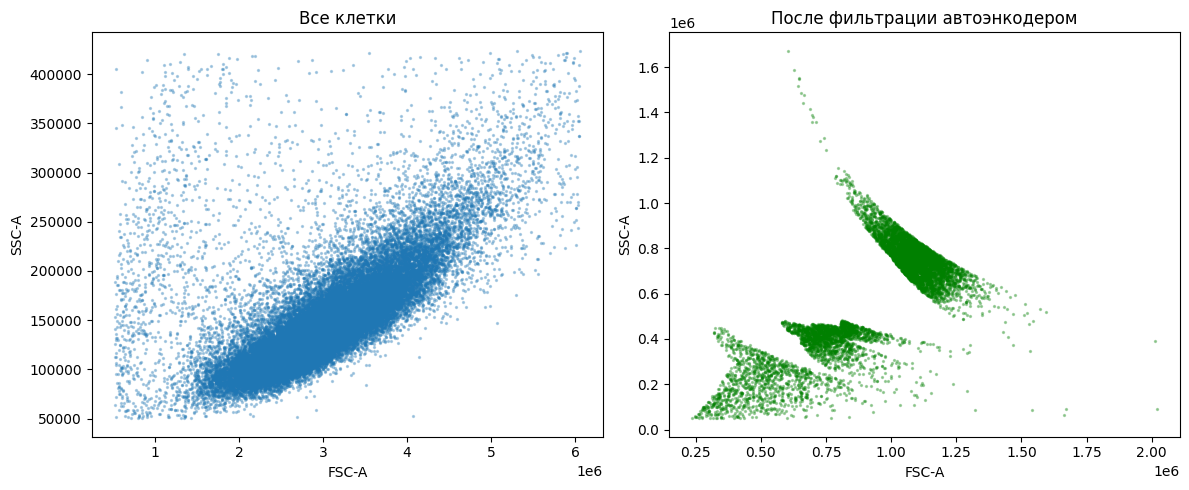

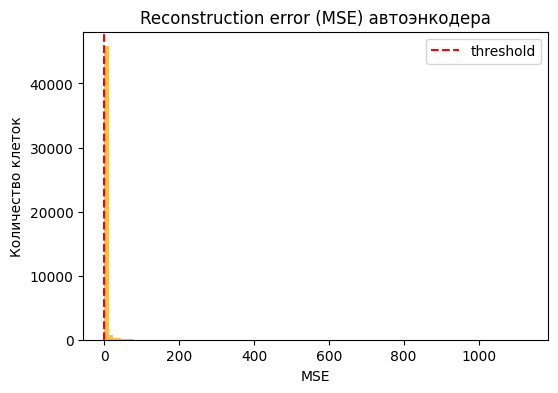

In [26]:
import matplotlib.pyplot as plt

np.random.seed(0)
n_cells = 50000

# Генерация синтетических "нормальных" клеток
channel1 = np.random.normal(loc=1e5, scale=5e4, size=n_cells)
channel2 = np.random.normal(loc=5e5, scale=1e5, size=n_cells)

df = pd.read_parquet("E:/parquet/XFG_58-24-H15K(sa55)_A11_26aee69a-ce9a-11f0-b3e2-f02f74d321c5.parquet") 
df = df[["FSC-H", "SSC-H", "FSC-A", "SSC-A", "FITC-A"]]
# Фильтруем стат. выбросы по 1% и 99% квантилям
for col in ['FSC-A','SSC-A']:
    q_low, q_high = df[col].quantile([0.01, 0.99])
    df = df[(df[col] >= q_low) & (df[col] <= q_high)]
df_s = df.copy()
# df_s = robust_scale_df(df, ["SSC-A", "FSC-A"])

df2 = pd.read_parquet("E:/parquet/EG.5_58-Fc_11_d4e54875-ce9a-11f0-8905-f02f74d321c5.parquet")
df2 = df2[["FSC-H", "SSC-H", "FITC-A", "FSC-A", "SSC-A", "FITC-A"]]
# Фильтруем стат. выбросы по 1% и 99% квантилям
for col in ['FSC-A','SSC-A']:
    q_low, q_high = df2[col].quantile([0.01, 0.99])
    df2 = df2[(df2[col] >= q_low) & (df2[col] <= q_high)]
df2_s = df2.copy()
# df2_s = robust_scale_df(df2, ["SSC-A", "FSC-A"])

# --- 1. Обучение автоэнкодера ---
model_dict = fit_autoencoder(df_s, cols=['FSC-A', 'SSC-A'], cofactor=5, latent_dim=2, epochs=100)

# --- 2. Применение автоэнкодера для фильтрации ---
is_inlier, rec_err = predict_anomaly_autoencoder(model_dict, df2_s)

print(f"Сохраняем {is_inlier.sum()} / {len(df_s)} клеток ({100*is_inlier.mean():.1f}%)")

# --- 3. Визуализация: исходные vs фильтрованные ---
fig, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].scatter(df_s['FSC-A'], df_s['SSC-A'], s=2, alpha=0.3)
axes[0].set_title("Все клетки")

axes[1].scatter(df2_s.loc[is_inlier,'FSC-A'], df2_s.loc[is_inlier,'SSC-A'], s=2, alpha=0.3, color='green')
axes[1].set_title("После фильтрации автоэнкодером")

for ax in axes:
    ax.set_xlabel('FSC-A')
    ax.set_ylabel('SSC-A')

plt.tight_layout()
plt.show()

# --- 4. Гистограмма ошибок восстановления ---
plt.figure(figsize=(6,4))
plt.hist(rec_err, bins=100, color='orange', alpha=0.7)
plt.axvline(model_dict['threshold'], color='red', linestyle='--', label='threshold')
plt.title("Reconstruction error (MSE) автоэнкодера")
plt.xlabel("MSE")
plt.ylabel("Количество клеток")
plt.legend()
plt.show()

c:\Users\Professional\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Professional\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Train inliers: 37459 / 38416 (97.5%)


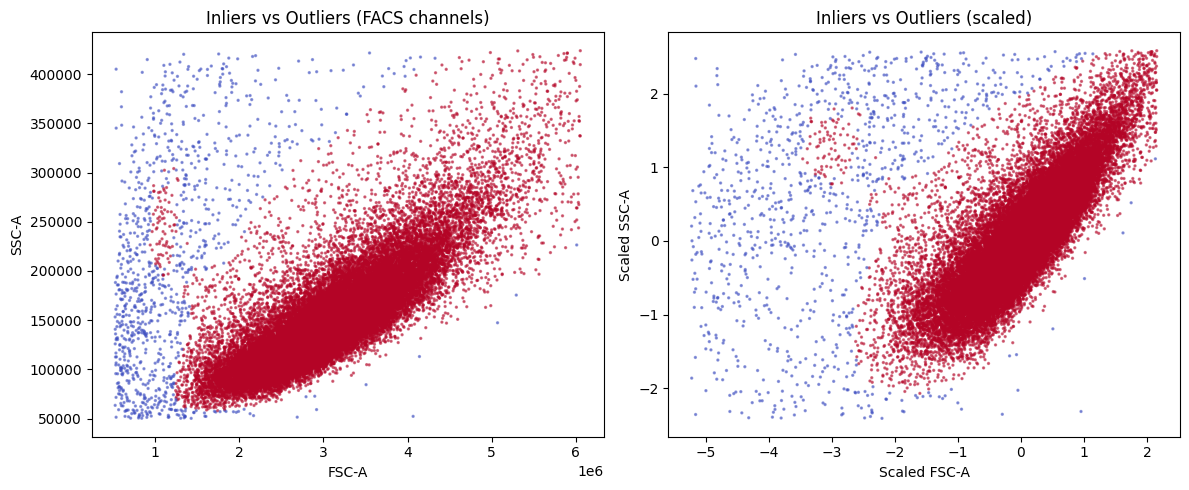

Predicted inliers: 29 / 48020 (0.1%)


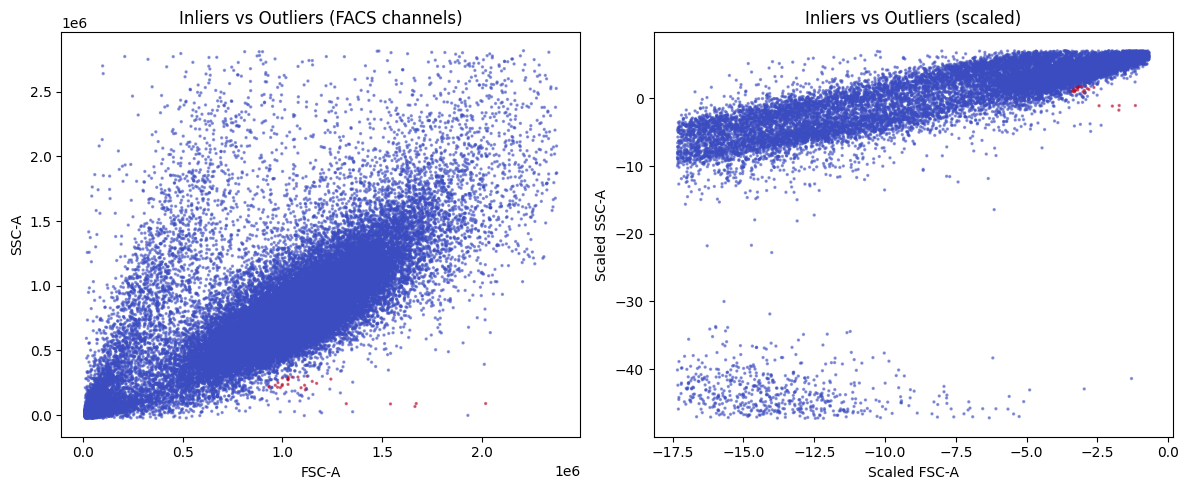

Predicted inliers: 35062 / 35842 (97.8%)


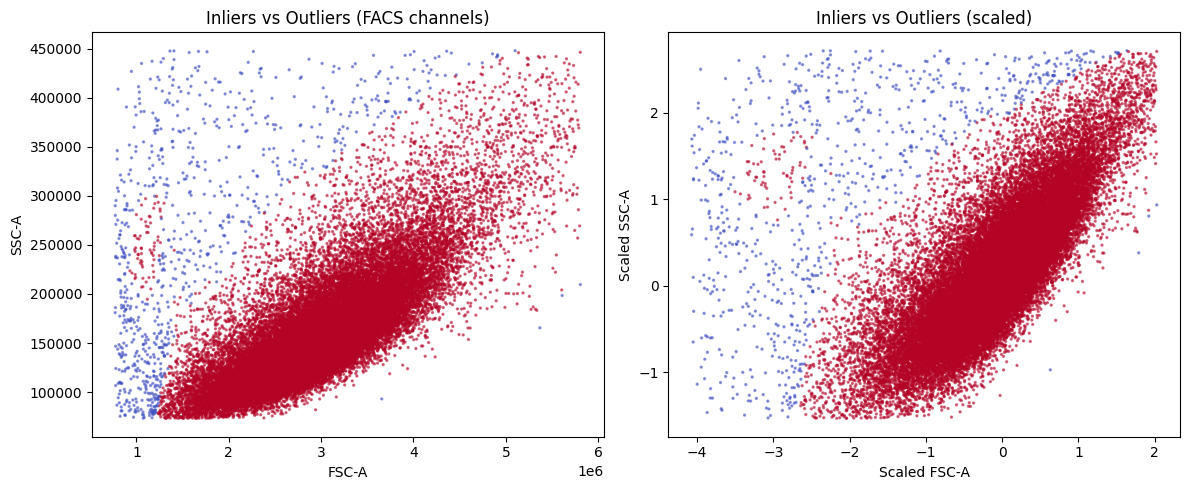

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
import hdbscan
from hdbscan import approximate_predict

# --- 1. Выбираем колонки и фильтруем квантильные выбросы ---
cols = ['FSC-A', 'SSC-A']
cofactor = 5

def preprocess_df(df, cols=cols, cofactor=5, scaler=None):
    df = df.copy()
    for col in cols:
        q_low, q_high = df[col].quantile([0.01,0.99])
        df = df[(df[col] >= q_low) & (df[col] <= q_high)]
    X = np.arcsinh(df[cols]/cofactor)
    if scaler is None:
        scaler = RobustScaler()
        Xs = scaler.fit_transform(X)
    else:
        Xs = scaler.transform(X)
    return df, Xs, scaler

# --- Обучение HDBSCAN ---
def fit_hdbscan(df_train, cols=cols, cofactor=5, min_cluster_size=60, min_samples=60):
    df_s, Xs, scaler = preprocess_df(df_train, cols=cols, cofactor=cofactor)
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                                min_samples=min_samples,
                                prediction_data=True)
    labels = clusterer.fit_predict(Xs)
    is_inlier = labels >= 0
    print(f"Train inliers: {is_inlier.sum()} / {len(df_s)} ({100*is_inlier.mean():.1f}%)")
    return clusterer, scaler, df_s, Xs, is_inlier

# --- Предсказание inliers на новых данных ---
def predict_inliers(clusterer, scaler, df, cols=cols, cofactor=5):
    df_s, Xs, _ = preprocess_df(df, cols=cols, cofactor=cofactor, scaler=scaler)
    labels, strengths = approximate_predict(clusterer, Xs)
    is_inlier = labels >= 0
    print(f"Predicted inliers: {is_inlier.sum()} / {len(df_s)} ({100*is_inlier.mean():.1f}%)")
    return df_s, Xs, is_inlier

# --- Визуализация ---
def plot_inliers(df_s, Xs, is_inlier):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.scatter(df_s['FSC-A'], df_s['SSC-A'], c=is_inlier, cmap='coolwarm', s=2, alpha=0.5)
    plt.xlabel('FSC-A'); plt.ylabel('SSC-A')
    plt.title('Inliers vs Outliers (FACS channels)')

    plt.subplot(1,2,2)
    plt.scatter(Xs[:,0], Xs[:,1], c=is_inlier, cmap='coolwarm', s=2, alpha=0.5)
    plt.xlabel('Scaled FSC-A'); plt.ylabel('Scaled SSC-A')
    plt.title('Inliers vs Outliers (scaled)')
    plt.tight_layout()
    plt.show()

df = pd.read_parquet("E:/parquet/XFG_58-24-H15K(sa55)_A11_26aee69a-ce9a-11f0-b3e2-f02f74d321c5.parquet") 
df = df[["FSC-H", "SSC-H", "FSC-A", "SSC-A", "FITC-A"]]

df2 = pd.read_parquet("E:/parquet/EG.5_58-Fc_11_d4e54875-ce9a-11f0-8905-f02f74d321c5.parquet")
df2 = df2[["FSC-H", "SSC-H", "FSC-A", "SSC-A", "FITC-A"]]

df3 = pd.read_parquet("E:/parquet/NB.1.8.1_SA55_B11_ed10f706-ce99-11f0-8b58-f02f74d321c5.parquet")
df3 = df3[["FSC-H", "SSC-H", "FSC-A", "SSC-A", "FITC-A"]]

clusterer, scaler, df_train_s, Xs_train, inliers_train = fit_hdbscan(df)
plot_inliers(df_train_s, Xs_train, inliers_train)

# Проверка на df2
df2_s, Xs2, inliers2 = predict_inliers(clusterer, scaler, df2)
plot_inliers(df2_s, Xs2, inliers2)

# Проверка на df3
df3_s, Xs3, inliers3 = predict_inliers(clusterer, scaler, df3)
plot_inliers(df3_s, Xs3, inliers3)


In [4]:
pip install hdbscan

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/726.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/726.2 kB ? eta -:--:--
   -------------- ------------------------- 262.1/726.2 kB ? eta -:--:--
   ---------------------------------------- 726.2/726.2 kB 1.6 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.
